# Song Recommender

Mejoras:
1er Notebook: Extracción de las canciones de Billboard100 (web scrapping) y lo guarde en un CSV.

2do Notebook: Extracción de canciones de Spotify (+ features), guardar en un CSV o pickle y que entrene el modelo (kmeans) y guardarlo con un pickle. Puede ser uno con clusters y otro sin, o ambos.

3er Notebook: El que haga el input del user y ejecute la función final.

Spotify Client: guardarlo en un .txt para importación local. Eso no se subirá a GitHub

## Soup "Preparation"

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import time
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
url = "https://www.billboard.com/charts/hot-100"

In [4]:
response = requests.get(url)

In [5]:
response

<Response [200]>

In [6]:
soup = BeautifulSoup(response.content, "html.parser")

## Web Scrapping

Getting Songs

In [7]:
soup.select("span.chart-element__information__song.text--truncate.color--primary")[0].get_text()

'Mood'

In [8]:
song = []

for s in soup.select("span.chart-element__information__song.text--truncate.color--primary"):
    song.append(s.get_text())

Getting Artists

In [9]:
soup.select("span.chart-element__information__artist.text--truncate.color--secondary")[0].get_text()

'24kGoldn Featuring iann dior'

In [10]:
artist = []

for a in soup.select("span.chart-element__information__artist.text--truncate.color--secondary"):
    artist.append(a.get_text())

Ranking Status (Steady, Rising or Failing

## Setting the DataFrame

In [11]:
billboard_hot100 = pd.DataFrame({"song":song,
                         "artist(s)":artist
                         })

In [12]:
billboard_hot100

,song,artist(s)
0,Mood,24kGoldn Featuring iann dior
1,Positions,Ariana Grande
2,Laugh Now Cry Later,Drake Featuring Lil Durk
3,Blinding Lights,The Weeknd
4,I Hope,Gabby Barrett Featuring Charlie Puth
...,...,...
95,Happy Does,Kenny Chesney
96,So Done,The Kid LAROI
97,Thick,DJ Chose Featuring BeatKing
98,La Toxica,Farruko


## Spotify API

In [13]:
#Import library
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [14]:
#Initialize SpotiPy with user credentias
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
    client_id="cee28011954344218ad66aefe89e71f8",
    client_secret="7007f507e93a4d668d4ccf52393bbe96"))

### Obtaining Info Playlist

In [15]:
def get_playlist_tracks(username,playlist_id):
    results = spotify.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = spotify.next(results)
        tracks.extend(results['items'])
    return tracks

playlist = get_playlist_tracks("spotify", "spotify:playlist:1G8IpkZKobrIlXcVPoSIuf")

In [16]:
def playlist_info(playlist):
    song_names = []
    artist_names = []
    song_URI = []
    features = []
    i = 0
    
    for result in playlist:
        if result["is_local"] == False:
            i += 1
            song_names.append(result["track"]["name"])
            artist_names.append(result["track"]["artists"][0]["name"])
            song_URI.append(result["track"]["uri"])
            if i == 100:
                i = 0
                features.append(spotify.audio_features(song_URI))
                song_URI = []    
    
    features.append(spotify.audio_features(song_URI)) 
    
    correct_feature = [f for feature in features for f in feature]
    
    return song_names, artist_names, correct_feature

songs, artists, correct_feature = playlist_info(playlist)

In [17]:
def total_features(info_features):
    mode = []
    acousticness = []
    danceability = []
    energy = []
    instrumentalness = []
    liveness = []
    loudness = []
    speechiness = []
    valence = []
    tempo = []
    
    for feature in info_features:
        mode.append(feature["mode"])
        acousticness.append(feature["acousticness"])
        danceability.append(feature["danceability"])
        energy.append(feature["energy"])
        instrumentalness.append(feature["instrumentalness"])
        liveness.append(feature["liveness"])
        loudness.append(feature["loudness"])
        speechiness.append(feature["speechiness"])
        valence.append(feature["valence"])
        tempo.append(feature["tempo"])
        
    
    df = pd.DataFrame({"song":songs,
                       "artist":artists,
                       "danceability":danceability,
                       "energy":energy,
                       "mode":mode,
                       "acousticness":acousticness,
                       "instrumentalness":instrumentalness,
                       "liveness":liveness,
                       "loudness":loudness,
                       "speechiness":speechiness,
                       "valence":valence,
                       "tempo":tempo
                      })
    
    return df

complete_list_song_artist_features = total_features(correct_feature)

In [18]:
complete_list_song_artist_features

,song,artist,danceability,energy,mode,acousticness,instrumentalness,liveness,loudness,speechiness,valence,tempo
0,Like a Rolling Stone,Bob Dylan,0.483,0.721,1,0.729000,0.000000,0.1890,-6.836,0.0320,0.562,95.261
1,Smells Like Teen Spirit,Nirvana,0.485,0.863,1,0.000012,0.016200,0.1380,-9.027,0.0495,0.767,116.835
2,A Day In The Life - Remastered,The Beatles,0.364,0.457,0,0.290000,0.000106,0.9220,-14.162,0.0675,0.175,163.219
3,Good Vibrations (Mono),The Beach Boys,0.398,0.413,1,0.082200,0.000025,0.0891,-10.934,0.0388,0.331,133.574
4,(I Can't Get No) Satisfaction - Mono Version /...,The Rolling Stones,0.725,0.853,1,0.034800,0.127000,0.1960,-7.842,0.0353,0.904,136.282
...,...,...,...,...,...,...,...,...,...,...,...,...
9931,Here It Goes Again,OK Go,0.537,0.882,1,0.000342,0.000091,0.1200,-2.306,0.0403,0.810,145.729
9932,Be Quiet and Drive (Far Away),Deftones,0.206,0.965,1,0.000010,0.827000,0.3670,-5.116,0.0790,0.168,92.615
9933,That Is Rock’n’Roll,The Coasters,0.518,0.732,1,0.769000,0.000000,0.1500,-9.358,0.1790,0.782,129.426
9934,She Cracked,Jonathan Richman & The Modern Lovers,0.515,0.843,1,0.000131,0.000064,0.2030,-6.839,0.0293,0.520,146.325


#### Clustering

In [19]:
playlist_for_cluster = complete_list_song_artist_features.copy()

In [20]:
playlist_for_cluster.drop(labels=["song", "artist"], axis=1, inplace=True)
playlist_for_cluster.head()

,danceability,energy,mode,acousticness,instrumentalness,liveness,loudness,speechiness,valence,tempo
0,0.483,0.721,1,0.729000,0.000000,0.1890,-6.836,0.0320,0.562,95.261
1,0.485,0.863,1,0.000012,0.016200,0.1380,-9.027,0.0495,0.767,116.835
2,0.364,0.457,0,0.290000,0.000106,0.9220,-14.162,0.0675,0.175,163.219
3,0.398,0.413,1,0.082200,0.000025,0.0891,-10.934,0.0388,0.331,133.574
4,0.725,0.853,1,0.034800,0.127000,0.1960,-7.842,0.0353,0.904,136.282


In [21]:
#initialize the transformer
scaler = StandardScaler()

In [22]:
playlist_scaled = scaler.fit_transform(playlist_for_cluster)

In [23]:
pd.DataFrame(playlist_scaled)

,0,1,2,3,4,5,6,7,8,9
0,-0.481868,0.409300,0.648886,1.387547,-0.444967,-0.008452,0.598586,-0.516449,-0.060482,-0.947708
1,-0.469779,1.025073,0.648886,-0.922023,-0.376796,-0.337947,0.027648,-0.280351,0.774642,-0.175184
2,-1.201180,-0.735516,-1.541104,-0.003287,-0.444521,4.727237,-1.310448,-0.037506,-1.637033,1.485740
3,-0.995663,-0.926319,0.648886,-0.661637,-0.444861,-0.653875,-0.469285,-0.424708,-1.001524,0.424208
4,0.980935,0.981708,0.648886,-0.811809,0.089462,0.036773,0.336439,-0.471928,1.332750,0.521177
...,...,...,...,...,...,...,...,...,...,...
9931,-0.155458,1.107465,0.648886,-0.920978,-0.444586,-0.454240,1.779028,-0.404471,0.949815,0.859456
9932,-2.156234,1.467388,0.648886,-0.922030,3.035139,1.141552,1.046789,0.117644,-1.665550,-1.042457
9933,-0.270306,0.457001,0.648886,1.514274,-0.444967,-0.260419,-0.058605,1.466780,0.835749,0.275676
9934,-0.288440,0.938344,0.648886,-0.921647,-0.444699,0.081998,0.597804,-0.552876,-0.231580,0.880797


In [24]:
#Initialize the model
kmeans = KMeans(n_clusters=8)

In [25]:
#Fit the model
kmeans.fit(playlist_scaled)

KMeans()

In [26]:
# Predicting / Assigning the clusters:
clusters = kmeans.predict(playlist_scaled)

In [27]:
clusters

array([5, 6, 2, ..., 5, 1, 6])

In [28]:
# Check the size of the clusters
pd.Series(clusters).value_counts()

6    2001
4    1620
1    1583
5    1399
3    1318
0     879
7     584
2     552
dtype: int64

#### Finding the inertia_ and optimal n of clusters

In [29]:
kmeans.inertia_

52160.31632684173

Elbow Method

In [30]:
K = range(2, 20)

inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(playlist_scaled)
    inertia.append(kmeans.inertia_)

print(inertia)

[82378.05890282053, 74463.08609118211, 68056.59252000279, 62377.37250043256, 57888.03521736896, 54322.95128472512, 52159.79849439811, 50106.95313721412, 48298.58024488645, 46940.077043987425, 45226.49570050656, 44063.485991272704, 43165.07138821845, 42287.41505896886, 41377.663720714154, 40780.06050312251, 39919.98816459366, 39307.7975222873]


Text(0.5, 1.0, 'Elbow Method showing the optimal k')

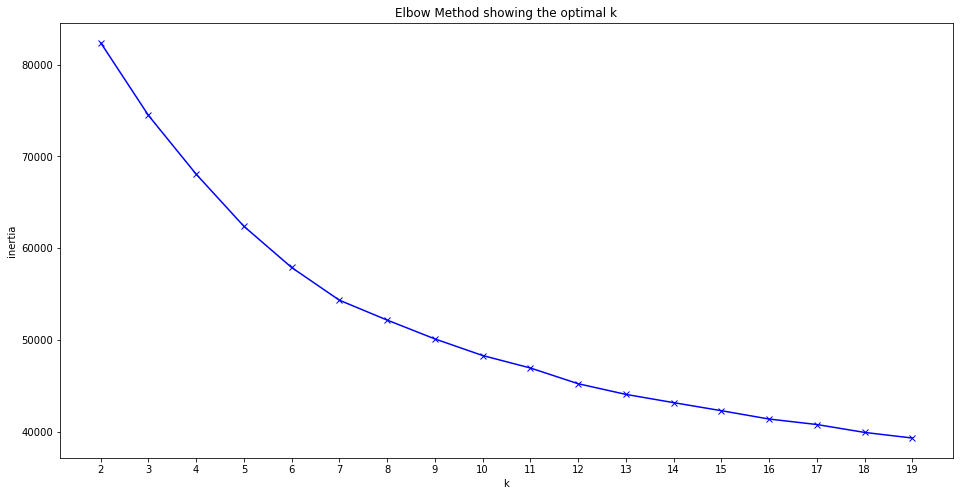

In [31]:
# Plot the results
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Silhoutte Score

In [32]:
from sklearn.metrics import silhouette_score

# repeat the same process, now with the silhouette score
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(playlist_scaled)
    silhouette.append(silhouette_score(X=playlist_scaled, labels=kmeans.predict(playlist_scaled)))

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

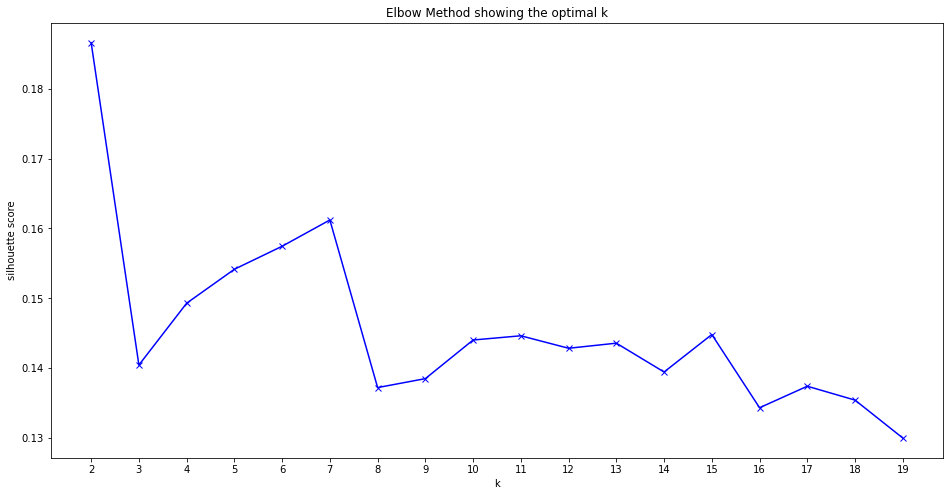

In [33]:
# plot
plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

##### The proper amount of clusters are 7. Let's update KMeans

In [34]:
kmeans = KMeans(n_clusters=7)

In [35]:
kmeans.fit(playlist_scaled)

KMeans(n_clusters=7)

In [36]:
clusters = kmeans.predict(playlist_scaled)

In [37]:
pd.Series(clusters).value_counts()

1    2533
5    1912
2    1761
3    1653
0     903
6     587
4     587
dtype: int64

In [38]:
complete_list_song_artist_features["cluster"] = clusters

In [39]:
complete_list_song_artist_features.head()

,song,artist,danceability,energy,mode,acousticness,instrumentalness,liveness,loudness,speechiness,valence,tempo,cluster
0,Like a Rolling Stone,Bob Dylan,0.483,0.721,1,0.729000,0.000000,0.1890,-6.836,0.0320,0.562,95.261,1
1,Smells Like Teen Spirit,Nirvana,0.485,0.863,1,0.000012,0.016200,0.1380,-9.027,0.0495,0.767,116.835,1
2,A Day In The Life - Remastered,The Beatles,0.364,0.457,0,0.290000,0.000106,0.9220,-14.162,0.0675,0.175,163.219,4
3,Good Vibrations (Mono),The Beach Boys,0.398,0.413,1,0.082200,0.000025,0.0891,-10.934,0.0388,0.331,133.574,2
4,(I Can't Get No) Satisfaction - Mono Version /...,The Rolling Stones,0.725,0.853,1,0.034800,0.127000,0.1960,-7.842,0.0353,0.904,136.282,1


## Running the final function

In [51]:
#User inputs a song. If it's on the DF, it will return another one, if not it will search on Spotify.
def input_song(df):
    choice = input("Welcome to the Song Recommender Pro-9000. Tell me one song and I will recommend you another one:\n").lower()
    
    if choice in df.str.lower().values:
        return 1, choice
    else:
        return 0, choice

In [58]:
song, choice = input_song(billboard_hot100["song"])

if song == 1:
    suggestion = billboard_hot100.sample()
    suggestion_song = suggestion["song"].values.flatten()
    suggestion_artist = suggestion["artist(s)"].values.flatten()
    suggestion_song = str(suggestion_song).lstrip("[").rstrip("]")
    suggestion_artist = str(suggestion_artist).lstrip("[").rstrip("]")
    
    time.sleep(1.5)
    print("Loading..")
    time.sleep(1.5)
    print("Loading...")
    time.sleep(0.5)
    print("We found something!")
    print(f"Here's our recommedation: {suggestion_song} from {suggestion_artist}. What a hit!")

elif song == 0:
    spoti_song = spotify.search(q=choice)
    while not spoti_song["tracks"]["items"]:
        print("Song not deteceted. Please introduce another song.")
        song, choice = input_song(billboard_hot100["song"])
        spoti_song = spotify.search(q=choice)
        
    print(spoti_song["tracks"]["items"][0]["name"], " - ", spoti_song["tracks"]["items"][0]["artists"][0]["name"])
    song_features_spoti = pd.DataFrame(spotify.audio_features(spoti_song["tracks"]["items"][0]["uri"]))
    spoti_features = song_features_spoti[["danceability", "energy", "mode", "acousticness", "instrumentalness", "liveness",
                      "loudness", "speechiness", "valence", "tempo"]]
    
    features_spoti_scaled = scaler.transform(spoti_features)
    spoti_cluster = kmeans.predict(features_spoti_scaled)
    match_table_spoti_input = complete_list_song_artist_features[complete_list_song_artist_features["cluster"] == int(spoti_cluster)]["song"]
    spoti_suggestion = match_table_spoti_input.sample()
    clean_suggestion = list(spoti_suggestion)
    clean_suggestion_2 = str(clean_suggestion).lstrip("[").rstrip("]")
    
    
    print("Wops, seems your song is not hot right now! Let me find you something else.")

    time.sleep(1.5)
    print("Loading..")
    time.sleep(1.5)
    print("Loading...")
    time.sleep(0.5)
    
    print("Finally! Here's your perfect song:")
    print(clean_suggestion_2)

Welcome to the Song Recommender Pro-9000. Tell me one song and I will recommend you another one:
wqwqw
Song not deteceted. Please introduce another song.
Welcome to the Song Recommender Pro-9000. Tell me one song and I will recommend you another one:
positions
positions  -  Ariana Grande
Wops, seems your song is not hot right now! Let me find you something else.
Loading..
Loading...
Finally! Here's your perfect song:
'Drops of Jupiter (Tell Me)'


#### Future Improvements

1st Notebook: Song extraction from Billboard100 and Store it into a CSV (only Web Scrapping)

2nd Notebook: Song and features extraction from Spotify, store it into a CSV/pickle, train the model (kmeans) and store it into a pickle. 

3rd Notebook: Just the input from the user and run all the model.

Spotify Client: Store it into a .txt in local for importing it.

Create a "while" loop that looks first if it's in Billboard or Spotify. If in Billboard, execute the first function, if not, execute

Crear un while loop que primero mire si está en Billboard o en Spotify. Si está en Billboard ejecutar la primera función, sino ejecutar la función en Spoti.

La función busca todo en Spoti.